In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

# Task 1: Advanced Objective Function and Use Case
### Derive the objective function for Logistic Regression using Maximum Likelihood Estimation (MLE). Do some research on the MAP technique for Logistic Regression, include your research on how this technique is different from MLE (include citations).

$$\hat{\theta}_{\text{MLE}} = \arg\min_{\theta} L(\theta)$$

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta} P(D \mid \theta)$$

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta} \ \sigma(w^T x)^y (1 - \sigma(w^T x))^{1-y}$$

Let $z = w^T x$

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta} \ \sigma(z)^y (1 - \sigma(z))^{1-y}$$

$$P(D \mid \theta) = \prod_{i=1}^{N} \sigma(z_i)^{y_i} (1 - \sigma(z_i))^{1-y_i}$$

$$\log P(D \mid \theta)
= \log \prod_{i=1}^{N} \sigma(z_i)^{y_i} (1 - \sigma(z_i))^{1-y_i}$$

$$\log P(D \mid \theta)
= \sum_{i=1}^{N} \log \left[ \sigma(z_i)^{y_i} (1 - \sigma(z_i))^{1-y_i} \right]$$

$$\log P(D \mid \theta) = \sum_{i=1}^{N} \left[y_i \log \sigma(z_i) + (1-y_i)\log(1 - \sigma(z_i))\right]$$

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta}\sum_{i=1}^{N} \left[y_i \log \sigma(z_i) + (1-y_i)\log(1 - \sigma(z_i))\right]$$

$$\text{NLL}(\theta) = - \sum_{i=1}^{N} \left[y_i \log \sigma(z_i) + (1-y_i)\log(1 - \sigma(z_i))\right]$$

$$\hat{\theta}_{\text{MLE}} = \arg\min_{\theta} \ \text{NLL}(\theta)$$

MLE and MAP are both methods used to estimate the parameters of a model. MLE is different from MAP in that MLE finds the parameter values that makes the observed data most likely. MAP on the other hand finds the parameter values that are the most likely given prior beliefs and the data. Both MAP and MLE are based on the likelihood function, however, MLE ignores prior knowledge while MAP uses it. When prior beliefs are uniform (aka all values of parameters are equally likely), MAP reduces to MLE.

Sources: https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation

https://www.cs.cornell.edu/courses/cs4780/2015fa/web/lecturenotes/lecturenote06.html


### 2. Define a machine learning problem you wish to solve using Logistic Regression. Justify why logistic regression is the best choice and compare it briefly to another linear classification model (cite your work if this other technique was not covered in class).

I wish to solve the patient churn problem using logistic regression. A patient churning means refers a patient stopping using the services of a medical practice, either by seeking care elsewhere or discontinuing treatment altogether. Logistic regression is the best choice for this model as whether a patient churned or not is a binary decision and you typically care for the probabilities of a patient churning rather than the label itself. Thus since the decisions are binary using a linear regression model does not make sense and since we care more about the probabilities just using a basic linear classification model does not make sense either. Additionally because we are using the linear model for logistic regression, we can see what features increase or decrease churn risk.

### 3. Discuss how your dataset corresponds to the variables in your equations, highlighting any assumptions in your derivation from part 1.

In the churn dataset I found, x corresponds to the features used to predict churn risk. This means that each feature is an independent variable or $x_i$. The target variable y is whether the patient churned or not (y=1 means the patient churned, y = 0 means the patient stayed)


# Task 2: Dataset and Advanced EDA

### 1. Select a publicly available dataset (excluding commonly used datasets such as Titanic, Housing Prices or Iris). Provide a link to your dataset. Ensure the dataset has at least 10 features to allow for more complex analysis.

https://www.kaggle.com/datasets/nudratabbas/patient-churn-prediction-dataset-for-healthcare?resource=download

### 2. Perform Exploratory Data Analysis (EDA), addressing potential multicollinearity among features. Use Variance Inflation Factor (VIF) to identify highly correlated variables and demonstrate steps to handle them.

In [2]:
# Read in the data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/patient_churn_dataset.csv')
X = df.drop(df.columns[-1], axis=1)
y = df[df.columns[-1]]


# Show example rows
display(df)

Mounted at /content/drive


,PatientID,Age,Gender,State,Tenure_Months,Specialty,Insurance_Type,Visits_Last_Year,Missed_Appointments,Days_Since_Last_Visit,...,Overall_Satisfaction,Wait_Time_Satisfaction,Staff_Satisfaction,Provider_Rating,Avg_Out_Of_Pocket_Cost,Billing_Issues,Portal_Usage,Referrals_Made,Distance_To_Facility_Miles,Churned
0,C20000,41,Female,PA,62,Pediatrics,Medicaid,1,0,564,...,3.5,4.9,3.8,4.2,306,0,0,3,21.4,1
1,C20001,43,Female,GA,44,Internal Medicine,Self-Pay,7,4,254,...,2.6,3.1,4.7,4.3,1851,0,0,0,47.6,1
2,C20002,21,Male,MI,120,Internal Medicine,Medicaid,15,5,89,...,1.6,4.4,2.1,4.7,391,0,0,2,7.1,0
3,C20003,65,Male,FL,118,General Practice,Private,10,3,135,...,2.6,4.3,4.3,4.9,808,0,0,0,11.6,1
4,C20004,18,Female,CA,70,Cardiology,Medicaid,5,4,696,...,2.2,4.0,4.1,4.4,866,0,0,0,10.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,C21995,31,Male,NC,78,Internal Medicine,Medicare,8,2,180,...,3.9,1.8,2.4,2.9,268,0,1,0,42.6,1
1996,C21996,45,Female,GA,69,Internal Medicine,Private,6,4,352,...,4.2,2.8,3.5,4.6,1257,1,0,3,15.4,1
1997,C21997,37,Male,NC,91,Family Medicine,Medicare,9,4,494,...,3.9,2.7,3.0,2.7,50,0,1,3,2.6,0
1998,C21998,69,Female,NY,5,Internal Medicine,Private,3,0,315,...,1.7,3.2,3.6,4.2,848,0,0,1,38.8,1


In [3]:

# Display data types
display(df.dtypes)

,0
PatientID,object
Age,int64
Gender,object
State,object
Tenure_Months,int64
Specialty,object
Insurance_Type,object
Visits_Last_Year,int64
Missed_Appointments,int64
Days_Since_Last_Visit,int64


In [4]:
# Show summary statistics (onlu sjows the numerical columns)
X.describe()

,Age,Tenure_Months,Visits_Last_Year,Missed_Appointments,Days_Since_Last_Visit,Overall_Satisfaction,Wait_Time_Satisfaction,Staff_Satisfaction,Provider_Rating,Avg_Out_Of_Pocket_Cost,Billing_Issues,Portal_Usage,Referrals_Made,Distance_To_Facility_Miles
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,52.856500,60.733500,7.614000,2.028000,366.130000,3.255000,3.289900,3.525900,3.736100,836.544000,0.078500,0.206000,1.483500,25.167400
std,15.836487,35.111293,4.672143,1.699312,212.890277,1.008595,1.009062,0.871613,0.733748,589.031896,0.269024,0.404532,1.100151,13.948284
min,18.000000,1.000000,0.000000,0.000000,1.000000,1.500000,1.500000,2.000000,2.500000,20.000000,0.000000,0.000000,0.000000,0.500000
25%,41.000000,30.000000,4.000000,0.000000,180.000000,2.400000,2.400000,2.775000,3.100000,326.000000,0.000000,0.000000,1.000000,12.800000
50%,54.000000,60.000000,8.000000,2.000000,363.000000,3.200000,3.300000,3.500000,3.800000,716.000000,0.000000,0.000000,1.000000,25.000000
75%,65.000000,92.250000,12.000000,3.000000,550.250000,4.100000,4.100000,4.300000,4.400000,1368.250000,0.000000,0.000000,2.000000,37.200000
max,90.000000,120.000000,15.000000,5.000000,730.000000,5.000000,5.000000,5.000000,5.000000,1999.000000,1.000000,1.000000,3.000000,50.000000


In [5]:
# Check for null values
display(X.isnull().sum())
# None should be missing

,0
PatientID,0
Age,0
Gender,0
State,0
Tenure_Months,0
Specialty,0
Insurance_Type,0
Visits_Last_Year,0
Missed_Appointments,0
Days_Since_Last_Visit,0


In [6]:
categorical_cols = ['Gender', 'State', 'Specialty', 'Insurance_Type']
X = X.drop(columns=['Last_Interaction_Date'] + categorical_cols, errors='ignore')
# Had to drop categorical columns as with one-hot encoding VIF would not compute and would error
# Below is my code for One hot Encoding
# # Perform one hot encoding
# X = X.drop(columns=['Last_Interaction_Date'])
# X = pd.get_dummies(X)
# X


In [7]:
# Calculate VIF
X_numeric = X.drop(columns=['PatientID'], errors='ignore').astype(float)
vif = pd.DataFrame()
vif["features"] = X_numeric.columns
vif["VIF Factor"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
display(vif.round(2))

,features,VIF Factor
0,Age,10.88
1,Tenure_Months,3.90
2,Visits_Last_Year,4.06
3,Missed_Appointments,2.73
4,Days_Since_Last_Visit,3.84
5,Overall_Satisfaction,10.34
6,Wait_Time_Satisfaction,10.70
7,Staff_Satisfaction,13.93
8,Provider_Rating,19.99
9,Avg_Out_Of_Pocket_Cost,2.99


In [8]:
# Remove VIF features
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

X_numeric_cleaned = X_numeric.copy()

while True:
    vif_df = calculate_vif(X_numeric_cleaned)
    max_vif = vif_df['VIF'].max()
    if max_vif > 5:
        feature_to_remove = vif_df.loc[vif_df['VIF'].idxmax()]['feature']
        print(f"Removing {feature_to_remove} with VIF: {max_vif}")
        X_numeric_cleaned = X_numeric_cleaned.drop(columns=[feature_to_remove])
    else:
        break

print("Final VIF Factors:")
display(calculate_vif(X_numeric_cleaned).round(2))

Removing Provider_Rating with VIF: 19.994126540171088
Removing Staff_Satisfaction with VIF: 12.672554937459578
Removing Wait_Time_Satisfaction with VIF: 9.696164595187751
Removing Overall_Satisfaction with VIF: 8.753003144653702
Removing Age with VIF: 7.311761913860322
Final VIF Factors:


,feature,VIF
0,Tenure_Months,3.29
1,Visits_Last_Year,3.73
2,Missed_Appointments,2.65
3,Days_Since_Last_Visit,3.31
4,Avg_Out_Of_Pocket_Cost,2.67
5,Billing_Issues,1.08
6,Portal_Usage,1.24
7,Referrals_Made,2.55
8,Distance_To_Facility_Miles,3.48


### 3. Visualize the dataset's feature relationships, ensuring inclusion of at least two advanced visualization techniques (e.g., pair plots with KDE, heatmaps with clustering).


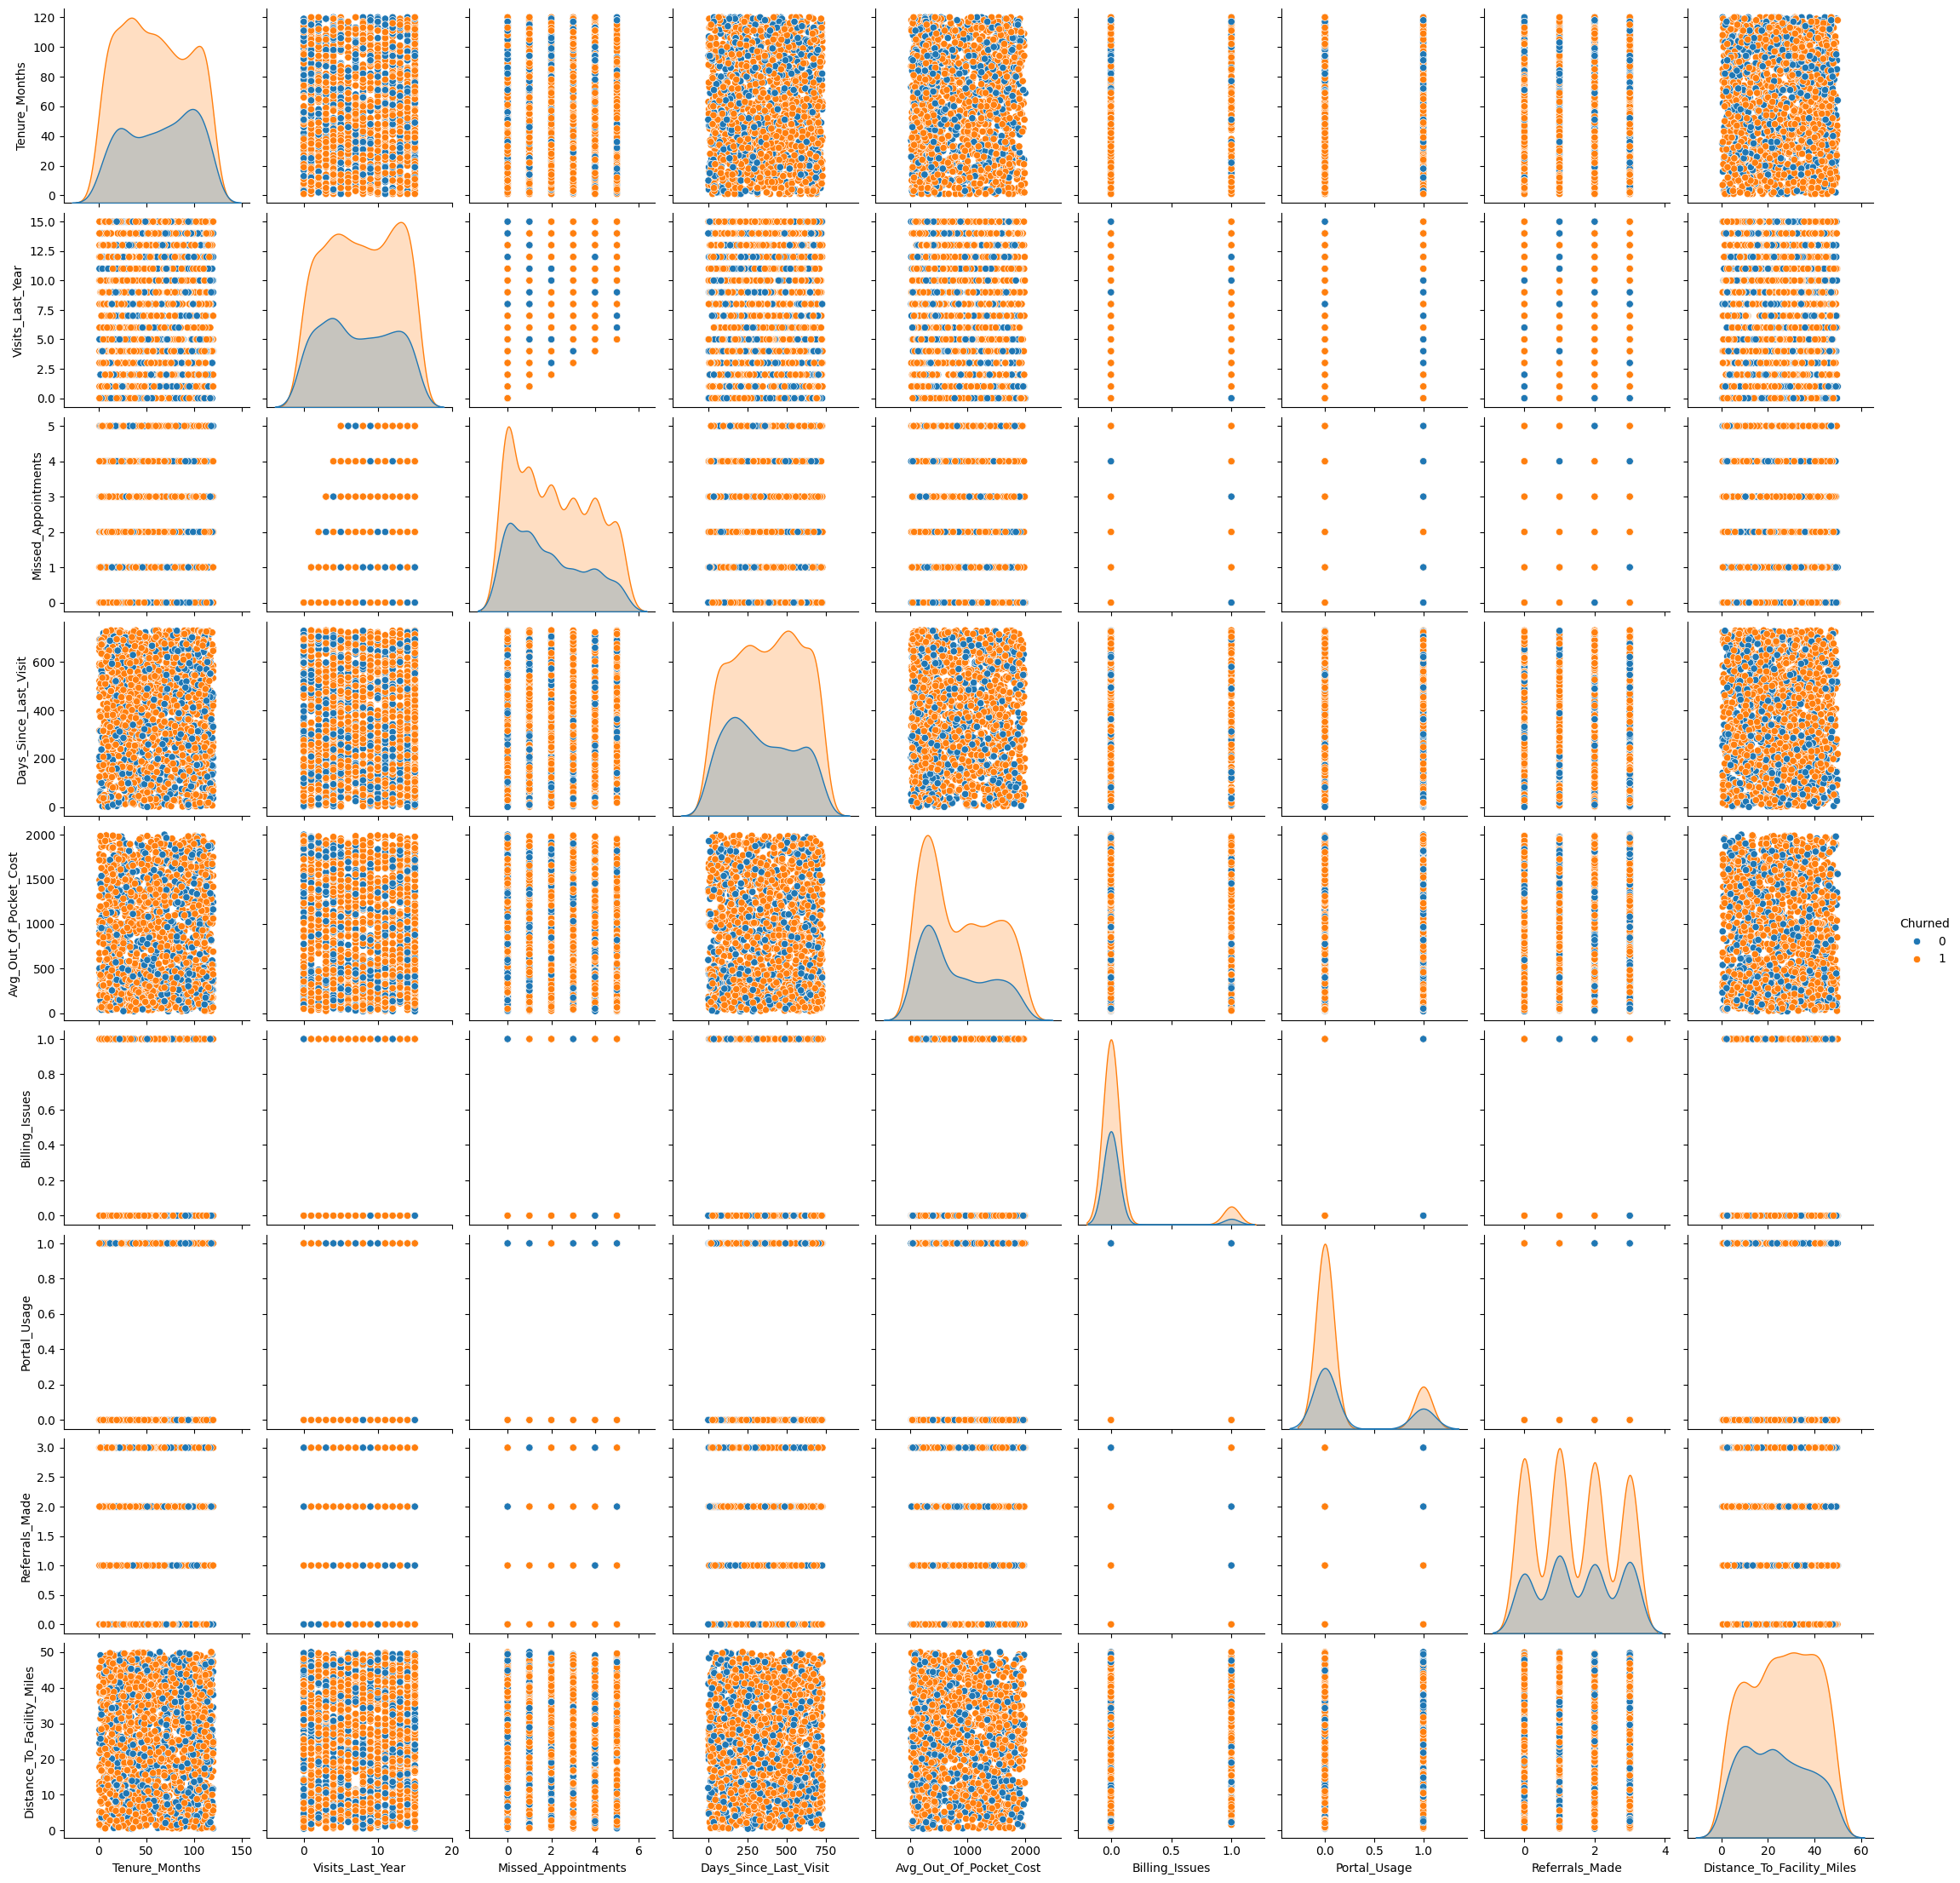

In [9]:
combined_df = pd.concat([X_numeric_cleaned, y], axis=1)
sns.pairplot(combined_df, diag_kind='kde', hue='Churned')

<Axes: >

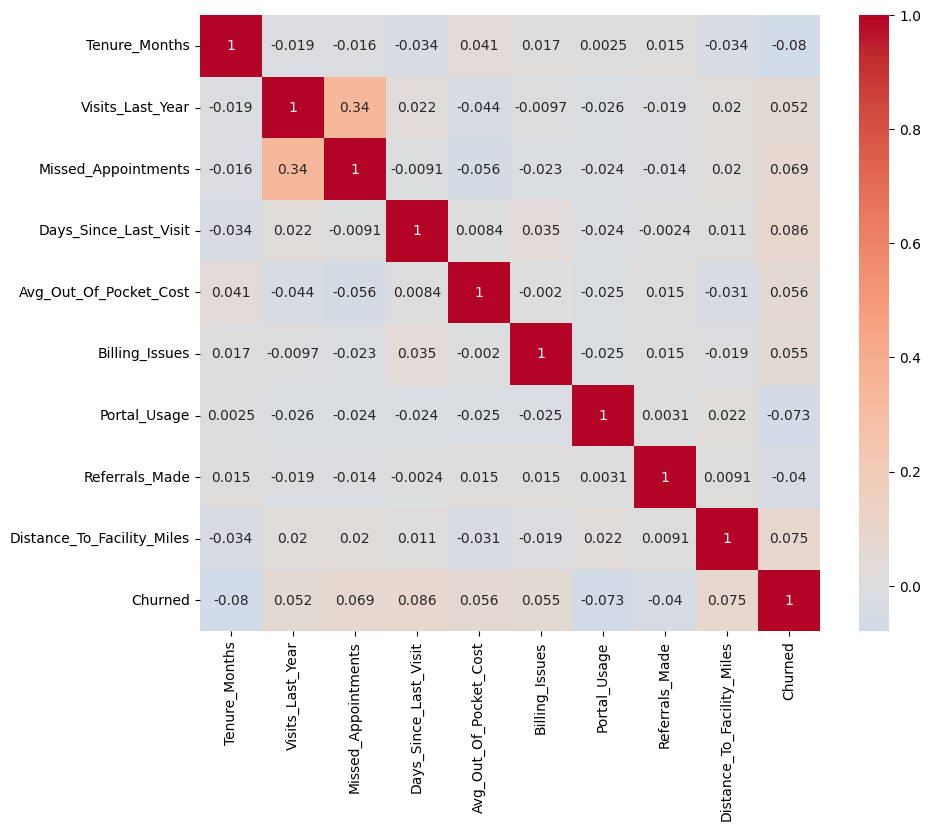

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm', center=0)

In [11]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_numeric_cleaned, y, train_size=0.7)

In [25]:
# Use standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Task 3: Logistic Regression Implementation

### 1. Implement Logistic Regression from scratch, including the vectorized implementation of cost function and gradient descent.

### 2. Implement and compare the three gradient descent variants (e.g., batch gradient descent, stochastic gradient descent, and mini-batch gradient descent). Explain their convergence properties with respect to your cost function.

In [26]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# NLL/cost function
def loss_func(y, y_pred):
  return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def batch_grad_descent(X, y, learn = 0.01, iters=10000):
  m, n = X.shape
  w = np.zeros(n)
  b = 0

  for i in range(iters):
    # Get preds
    z = np.dot(X, w) + b
    y_pred = sigmoid(z)

    # compute the gradients
    dw = np.dot(X.T, (y_pred - y)) / m
    db = np.sum(y_pred - y) / m

    # update weight and bias
    w -= learn * dw
    b -= learn * db

  return w, b

def stochastic_grad_descent(X, y, learn = 0.01, iters=10000):
  m, n = X.shape
  w = np.zeros(n)
  b = 0

  for i in range(iters):
    # Select a random data point
    random_index = np.random.randint(0, m)
    X_sample = X[random_index]
    y_sample = y[random_index]

    z = np.dot(X_sample, w) + b
    y_pred = sigmoid(z)

    # compute gradient with singular point
    dw = X_sample * (y_pred - y_sample)
    db = y_pred - y_sample

    # update weight and bias
    w -= learn * dw
    b -= learn * db

  return w, b

def mini_batch_grad_descent(X, y, learn = 0.01, iters=10000, batch_size = 50):
  m, n = X.shape
  w = np.zeros(n)
  b = 0

  for itr in range(iters):

    index = np.random.permutation(m)

    # create a batch of features and labels
    for i in range(0, m, batch_size):
      X_batch = X[index][i:i+batch_size]
      y_batch = y[index][i:i+batch_size]

      # get preds
      z = np.dot(X_batch, w) + b
      y_pred = sigmoid(z)

      # compute gradients
      dw = np.dot(X_batch.T, (y_pred - y_batch)) / batch_size
      db = np.sum(y_pred - y_batch) / batch_size

      # update weight and bias
      w -= learn * dw
      b -= learn * db

  return w, b

In [29]:
w_batch, b_batch = batch_grad_descent(X_train, y_train.values)
w_sgd, b_sgd = stochastic_grad_descent(X_train, y_train.values)
w_miniB, b_miniB = mini_batch_grad_descent(X_train, y_train.values)

#### Explaining Convergence Properties

Batch Gradient Descent
- Batch Gradient Descent has stable convergence due to the low variance in the gradients due to summing and averaging across the whole data set

Stochastic Gradient Descent
- Stochastic Gradient Descent has a higher variance due to only using one point and may osciliate around the minimum bouncing back and forth if the gradient or step size is too large

Mini-Batch
- Mini-Batch is a compromise between batch and stochastic, allowing for quicker convergence than batch gradient descent but less variance and osciliation than stochastic gradient descent

# Task 4: Optimization Techniques and Advanced Comparison

### 1. Implement or use packages to incorporate any three optimization algorithms (e.g., Momentum, RMSProp, Adam). Compare their performance with the vanilla stochastic gradient descent implementation from Task 3.

In [30]:
def stochastic_grad_descent_momentum(X, y, learn=0.01, iters=10000, decay=0.9):
    m, n = X.shape
    w = np.zeros(n)
    b = 0

    velocity_w = np.zeros(n)
    velocity_b = 0

    for i in range(iters):
        random_index = np.random.randint(0, m)
        X_sample = X[random_index]
        y_sample = y[random_index]

        z = np.dot(X_sample, w) + b
        y_pred = sigmoid(z)

        dw = X_sample * (y_pred - y_sample)
        db = y_pred - y_sample

        # momentum update
        velocity_w = decay * velocity_w + (1 - decay) * dw
        velocity_b = decay * velocity_b + (1 - decay) * db

        w -= learn * velocity_w
        b -= learn * velocity_b

    return w, b

def stochastic_grad_descent_rmsprop(X, y, learn=0.01, iters=10000, decay=0.9, eps=1e-8):
    m, n = X.shape
    w = np.zeros(n)
    b = 0

    squared_w = np.zeros(n)
    squared_b = 0 # Corrected typo: sb to squared_b

    for i in range(iters):
        random_index = np.random.randint(0, m)
        X_sample = X[random_index]
        y_sample = y[random_index]

        z = np.dot(X_sample, w) + b
        y_pred = sigmoid(z)

        dw = X_sample * (y_pred - y_sample)
        db = y_pred - y_sample

        # RMSProp update
        squared_w = decay * squared_w + (1 - decay) * (dw ** 2)
        squared_b = decay * squared_b + (1 - decay) * (db ** 2)

        w -= learn * dw / (np.sqrt(squared_w) + eps)
        b -= learn * db / (np.sqrt(squared_b) + eps)

    return w, b


def stochastic_grad_descent_adam(X, y, learn=0.01, iters=10000,
                                 decay1=0.9, decay2=0.999, eps=1e-8):
    m, n = X.shape
    w = np.zeros(n)
    b = 0

    momentum_w = np.zeros(n)
    velocity_w = np.zeros(n)
    momentum_b = 0
    velocity_b = 0

    t = 0

    for i in range(iters):
        t += 1
        random_index = np.random.randint(0, m)
        X_sample = X[random_index]
        y_sample = y[random_index]

        z = np.dot(X_sample, w) + b
        y_pred = sigmoid(z)

        dw = X_sample * (y_pred - y_sample)
        db = y_pred - y_sample

        # Adam moment updates
        momentum_w = decay1 * momentum_w + (1 - decay1) * dw
        velocity_w = decay2 * velocity_w + (1 - decay2) * (dw ** 2)

        momentum_b = decay1 * momentum_b + (1 - decay1) * db
        velocity_b = decay2 * velocity_b + (1 - decay2) * (db ** 2)

        # bias correction
        momentum_w_hat = momentum_w / (1 - decay1 ** t)
        velocity_w_hat = velocity_w / (1 - decay2 ** t)

        momentum_b_hat = momentum_b / (1 - decay1 ** t)
        velocity_b_hat = velocity_b / (1 - decay2 ** t)

        w -= learn * momentum_w_hat / (np.sqrt(velocity_w_hat) + eps)
        b -= learn * momentum_b_hat / (np.sqrt(velocity_b_hat) + eps)

    return w, b

In [31]:
w_momentum, b_momentum = stochastic_grad_descent_momentum(X_train, y_train.values)
w_rmsprop, b_rmsprop = stochastic_grad_descent_rmsprop(X_train, y_train.values)
w_adam, b_adam = stochastic_grad_descent_adam(X_train, y_train.values)

### 2. Define and use multiple evaluation metrics (e.g., precision, recall, F1 score) to analyze and interpret results for each algorithm.

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def predict(X, w, b, threshold=0.5):
  z = np.dot(X, w) + b
  y_prob = sigmoid(z)
  return (y_prob >= threshold).astype(int)

def evaluate(y_true, y_pred, model_name):
  print(f"{model_name}:")
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print("\n")


# Get predictions
y_pred_batch = predict(X_test, w_batch, b_batch)
y_pred_sgd = predict(X_test, w_sgd, b_sgd)
y_pred_miniB = predict(X_test, w_miniB, b_miniB)
y_pred_momentum = predict(X_test, w_momentum, b_momentum)
y_pred_rmsprop = predict(X_test, w_rmsprop, b_rmsprop)
y_pred_adam = predict(X_test, w_adam, b_adam)

# Evaluate
evaluate(y_test, y_pred_batch, "Batch Gradient Descent")
evaluate(y_test, y_pred_sgd, "Stochastic Gradient Descent")
evaluate(y_test, y_pred_miniB, "Mini-Batch Gradient Descent")
evaluate(y_test, y_pred_momentum, "SGD with Momentum")
evaluate(y_test, y_pred_rmsprop, "SGD with RMSProp")
evaluate(y_test, y_pred_adam, "SGD with Adam")

Batch Gradient Descent:
Accuracy: 0.6950
Precision: 0.7012
Recall: 0.9760
F1 Score: 0.8161


Stochastic Gradient Descent:
Accuracy: 0.6950
Precision: 0.7033
Recall: 0.9688
F1 Score: 0.8150


Mini-Batch Gradient Descent:
Accuracy: 0.6950
Precision: 0.7012
Recall: 0.9760
F1 Score: 0.8161


SGD with Momentum:
Accuracy: 0.6850
Precision: 0.7045
Recall: 0.9399
F1 Score: 0.8054


SGD with RMSProp:
Accuracy: 0.6733
Precision: 0.7107
Recall: 0.8918
F1 Score: 0.7910


SGD with Adam:
Accuracy: 0.6917
Precision: 0.7112
Recall: 0.9351
F1 Score: 0.8079




### 3. Perform a hyperparameter tuning process (manual or automated using grid search/random search) for each optimization algorithm and assess its impact on performance. If you have to do some research for these techniques, please cite your sources.

In [41]:
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

In [43]:
best_models = {}

#Batch Gradient Descent
best_models["Batch Gradient Descent"] = {"accuracy": 0}

for learn in [0.001, 0.01, 0.1]:
    w, b = batch_grad_descent(X_train, y_train.values, learn=learn)
    y_pred = predict(X_test, w, b)

    metrics = compute_metrics(y_test, y_pred)

    print(f"Batch GD | learn={learn}")
    print(metrics, "\n")

    if metrics["accuracy"] > best_models["Batch Gradient Descent"]["accuracy"]:
        best_models["Batch Gradient Descent"] = {
            "params": {"learn": learn},
            "accuracy": metrics["accuracy"],
            "precision": metrics["precision"],
            "recall": metrics["recall"],
            "f1": metrics["f1"]
        }

#SGD
best_models["Stochastic Gradient Descent"] = {"accuracy": 0}

for learn in [0.001, 0.01, 0.1]:
    w, b = stochastic_grad_descent(X_train, y_train.values, learn=learn)
    y_pred = predict(X_test, w, b)

    metrics = compute_metrics(y_test, y_pred)

    print(f"SGD | learn={learn}")
    print(metrics, "\n")

    if metrics["accuracy"] > best_models["Stochastic Gradient Descent"]["accuracy"]:
        best_models["Stochastic Gradient Descent"] = {
            "params": {"learn": learn},
            "accuracy": metrics["accuracy"],
            "precision": metrics["precision"],
            "recall": metrics["recall"],
            "f1": metrics["f1"]
        }

#mini-batch
best_models["Mini-Batch Gradient Descent"] = {"accuracy": 0}

for learn in [0.001, 0.01, 0.1]:
    for batch_size in [16, 32, 64]:
        w, b = mini_batch_grad_descent(X_train, y_train.values, learn=learn, batch_size=batch_size)
        y_pred = predict(X_test, w, b)

        metrics = compute_metrics(y_test, y_pred)

        print(f"Mini-Batch GD | learn={learn}, batch_size={batch_size}")
        print(metrics, "\n")

        if metrics["accuracy"] > best_models["Mini-Batch Gradient Descent"]["accuracy"]:
            best_models["Mini-Batch Gradient Descent"] = {
                "params": {"learn": learn, "batch_size": batch_size},
                "accuracy": metrics["accuracy"],
                "precision": metrics["precision"],
                "recall": metrics["recall"],
                "f1": metrics["f1"]
            }

#Momentum
best_models["SGD with Momentum"] = {"accuracy": 0}

for learn in [0.001, 0.01, 0.1]:
    for decay in [0.8, 0.9, 0.95]:
        w_momentum, b_momentum = stochastic_grad_descent_momentum(X_train, y_train.values, learn=learn, decay=decay)
        y_pred = predict(X_test, w_momentum, b_momentum)

        metrics = compute_metrics(y_test, y_pred)

        print(f"Momentum | learn={learn}, decay={decay}")
        print(metrics, "\n")

        if metrics["accuracy"] > best_models["SGD with Momentum"]["accuracy"]:
            best_models["SGD with Momentum"] = {
                "params": {"learn": learn, "decay": decay},
                "accuracy": metrics["accuracy"],
                "precision": metrics["precision"],
                "recall": metrics["recall"],
                "f1": metrics["f1"]
            }

# RMS Prop
best_models["SGD with RMSProp"] = {"accuracy": 0}

for learn in [0.001, 0.01, 0.1]:
    for decay in [0.8, 0.9, 0.95]:
        w_rmsprop, b_rmsprop = stochastic_grad_descent_rmsprop(X_train, y_train.values, learn=learn, decay=decay)
        y_pred = predict(X_test, w_rmsprop, b_rmsprop)

        metrics = compute_metrics(y_test, y_pred)

        print(f"RMSProp | learn={learn}, decay={decay}")
        print(metrics, "\n")

        if metrics["accuracy"] > best_models["SGD with RMSProp"]["accuracy"]:
            best_models["SGD with RMSProp"] = {
                "params": {"learn": learn, "decay": decay},
                "accuracy": metrics["accuracy"],
                "precision": metrics["precision"],
                "recall": metrics["recall"],
                "f1": metrics["f1"]
            }

#Adam
best_models["SGD with Adam"] = {"accuracy": 0}

for learn in [0.001, 0.01, 0.1]:
    for decay1 in [0.8, 0.9, 0.95]:
        for decay2 in [0.99, 0.999, 0.9999]:
            w_adam, b_adam = stochastic_grad_descent_adam(X_train, y_train.values, learn=learn, decay1=decay1, decay2=decay2)
            y_pred = predict(X_test, w_adam, b_adam)

            metrics = compute_metrics(y_test, y_pred)

            print(f"Adam | learn={learn}, decay1={decay1}, decay2={decay2}")
            print(metrics, "\n")

            if metrics["accuracy"] > best_models["SGD with Adam"]["accuracy"]:
                best_models["SGD with Adam"] = {
                    "params": {"learn": learn, "decay1": decay1, "decay2": decay2},
                    "accuracy": metrics["accuracy"],
                    "precision": metrics["precision"],
                    "recall": metrics["recall"],
                    "f1": metrics["f1"]
                }
#Best models
print("\nBEST MODEL PER OPTIMIZER:")
for model, info in best_models.items():
    print(model)
    print(f"  Params: {info['params']}")
    print(f"  Accuracy:  {info['accuracy']:.4f}")
    print(f"  Precision: {info['precision']:.4f}")
    print(f"  Recall:    {info['recall']:.4f}")
    print(f"  F1 Score:  {info['f1']:.4f}\n")


Batch GD | learn=0.001
{'accuracy': 0.6966666666666667, 'precision': 0.7010309278350515, 'recall': 0.9807692307692307, 'f1': 0.8176352705410822} 

Batch GD | learn=0.01
{'accuracy': 0.695, 'precision': 0.7012089810017271, 'recall': 0.9759615384615384, 'f1': 0.8160804020100503} 

Batch GD | learn=0.1
{'accuracy': 0.695, 'precision': 0.7012089810017271, 'recall': 0.9759615384615384, 'f1': 0.8160804020100503} 

SGD | learn=0.001
{'accuracy': 0.695, 'precision': 0.6998284734133791, 'recall': 0.9807692307692307, 'f1': 0.8168168168168168} 

SGD | learn=0.01
{'accuracy': 0.6966666666666667, 'precision': 0.708185053380783, 'recall': 0.9567307692307693, 'f1': 0.8139059304703476} 

SGD | learn=0.1
{'accuracy': 0.6666666666666666, 'precision': 0.7278481012658228, 'recall': 0.8293269230769231, 'f1': 0.7752808988764045} 

Mini-Batch GD | learn=0.001, batch_size=16
{'accuracy': 0.695, 'precision': 0.7012089810017271, 'recall': 0.9759615384615384, 'f1': 0.8160804020100503} 

Mini-Batch GD | learn=0.0

Tuning the hyperparameters had very minimal effects on the evaluations of the models with all the metrics changing very minorly. The SGD variants had the most fluctuations out of all models which makes sense due to the inherent randomness in it. While the accuracy did not change drastically, in some cases the recall would vary heavily, which would cause the variations in model accuracies. This shows the importance of hyperparameter tuning as even the small boosts in accuracy can be extremely important in industry especially if there are big underlying changes in metrics like recall or precision.

### 4. Conclude by discussing the practical trade-offs of the algorithms, including computational complexity, interpretability, and suitability for large-scale datasets.

1. Batch Gradient Descent


    Pros
    - Stable in convergence and the error gradient
    - Smooth and predictable updates

    Cons
    - Requires use of entire dataset, resulting in long compute times when trained on larger datasets (computationally intensive and large memory needed)

2. Stochastic Gradient Descent

    Pros
    - Smaller memory complexity than batch (only one needed at a time)
    - Faster computation time than batch gradient descent
    - Can escape local minimums from neural networks because of noisy updates

    Cons
    - Because we only use one point, the gradients are very noisy and can result in gradients going in non optimal directions, causing error to fluctuate up and down
    - Gradients less representative of the true loss
    - may never converge to exact minimum

3. Mini-Batch

    Pros
    - Computationally faster than Batch as we only process a subsection of the dataset
    - More stable and less variance in gradients than stochastic gradient descent leading to less oscillations
    - Balances speed and stability
    Cons
    - Slighlty slower than SGD and less accurate than batch gradient descent (gradient still an approximation)
    - Mini-batch has an additional hyper parameter in batch size that needs to be tuned


4. Momentum

    Pros
    - speeds up convergence by building momentum in gradient direction
    - reduces oscillations
    Cons
    - Can still overshoot if learning rate or momentum too high
    - Introduces an extra hyperparameter

5. RMSProp

    Pros
    - Adapts learning rate per parameter
    - Faster convergence
    Cons
    - Requires tuning of learning rate and decay rate
    - convergence path is less interpretable than traditional sgd or momentum

6. Adam

    Pros
    - Converges the fastest by combigning momentum and RMS prop
    - Really good for large data sets
    Cons
    - Lots of hyperparameters
    - Can stil converge to local minimums instead of global

<strong>Overall tradeoffs for all learning algorithms</strong>
- Balance between computational complexit and accuracy
- Balance between computational complexity and convergence rate for SGD optimizations (momentum, RMSProp)
- Simpler optimization algorithms like Batch and SGD are more interpretable than the less intuitive Adam or Momentums
- Stochastic Gradient descent methods (including the optimizations) are preferred for very large data sets due to computationa and memory demands
  - Mini-Batch is also included here and is very good
